## Implementing Portfolio insurance(CPPI) and drawdown constraints

# Lab session 2 and 3 have been combined here

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np 
%matplotlib inline
import edhec_risk_kit as erk

#Load the industry returns and total market index we previously created.
ind_return=erk.get_ind_returns()
tmi_return=erk.get_total_market_index_returns()

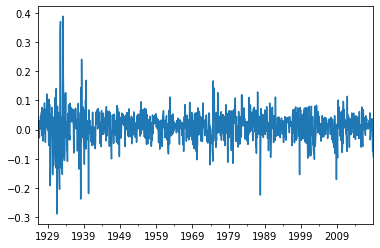

In [3]:
tmi_return.plot()

In [4]:
risky_r= ind_return["2000":][["Steel","Fin","Beer"]]
#Safe Asset


In [5]:
risky_r.shape

(228, 3)

In [6]:
risky_r.head()

,Steel,Fin,Beer
2000-01,-0.0277,-0.0442,-0.0228
2000-02,0.0684,-0.0849,-0.1164
2000-03,0.0349,0.1669,0.0013
2000-04,-0.0084,-0.0425,0.0368
2000-05,-0.0492,0.0506,0.1187


In [7]:
safe_r=pd.DataFrame().reindex_like(risky_r) #reindex_like is used to create another data frame with the same shape.

In [8]:
safe_r #Dataframe created with no initial values.

,Steel,Fin,Beer
2000-01,NaN,NaN,NaN
2000-02,NaN,NaN,NaN
2000-03,NaN,NaN,NaN
2000-04,NaN,NaN,NaN
2000-05,NaN,NaN,NaN
...,...,...,...
2018-08,NaN,NaN,NaN
2018-09,NaN,NaN,NaN
2018-10,NaN,NaN,NaN
2018-11,NaN,NaN,NaN


In [9]:
safe_r.shape

(228, 3)

In [10]:
safe_r[:]=0.03/12
start=1000
floor=0.8 #floor value=0.8*1000=800.

# 1.Cushion=(Asset Value- Floor Value)
# 2.Compute an allocation to safe and risky assets--->m*risky budget. m is multiplier.
# 3.Recompute the asset values based on the returns

In [11]:
%timeit erk.get_total_market_index_returns() #give you the average time it takes to run a function.

26.4 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
dates=risky_r.index
n_steps=len(dates)
account_value=start
floor_value=account_value*floor
m=3
account_history=pd.DataFrame().reindex_like(risky_r)
cushion_history=pd.DataFrame().reindex_like(risky_r)
risky_w_history=pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion=(account_value-floor_value)/account_value
    risky_w =m*cushion
    risky_w = np.minimum(risky_w,1)
    risky_w = np.maximum(risky_w,0)
    safe_w=1- risky_w
    risky_alloc=account_value*risky_w
    safe_alloc=account_value*safe_w
    #Update the account value for this time step.
    account_value=risky_alloc*(1+risky_r.iloc[step])+safe_alloc*(1+safe_r.iloc[step])
    # Save the values for later reference.
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value




In [13]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [14]:
risky_wealth=start*(1+risky_r).cumprod() #risky_wealth is basically the allocation in risky assets if CPPI had not been done.

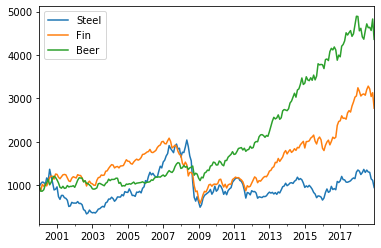

In [15]:
risky_wealth.plot()

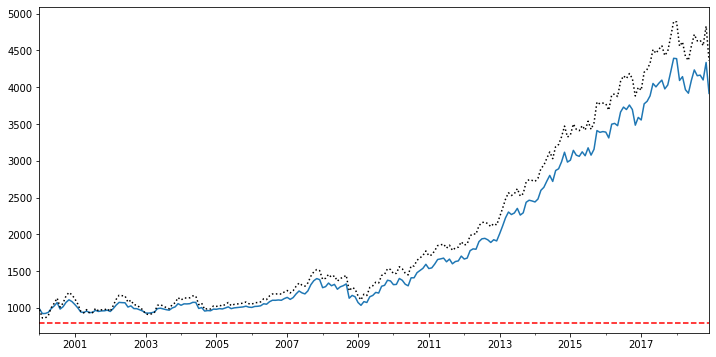

In [16]:
ax=account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax,style="k:")
ax.axhline(y=floor_value,color='r',linestyle='--')

## from the above graph it is clear that the dotted line is more volatile than the blue line. This is because the blue line incorporates CPPI(combination of beer and safe assets) while dotted line is investing only in Beer. 

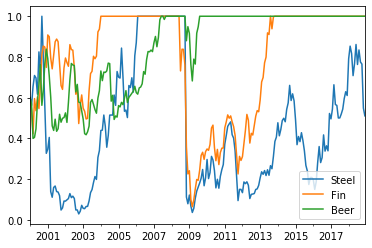

In [17]:
risky_w_history.plot()

# Here, after a point there is 100% investment in risky assets(for beer), meaning that after a point, the blue line and the dotted line will coincide, because at that point, the returns will be so high that is very unlikely that the returns will crash to the floor value(the horizontal dotted line). 

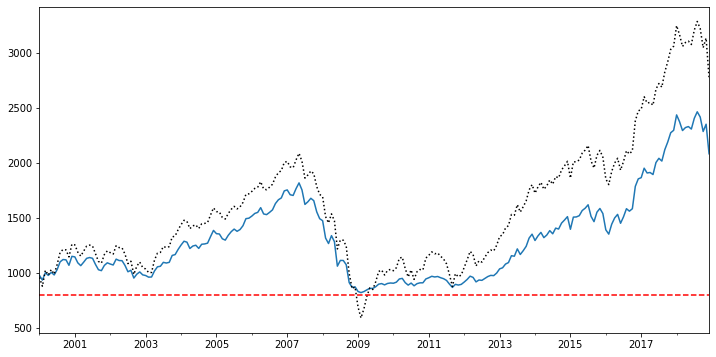

In [18]:
ind="Fin"
ax=account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax,style="k:")
ax.axhline(y=floor_value,color='r',linestyle='--')

# Note that, during the financial crash of 2009, the dotted line crashes to below the floor while the CPPI investement deftly bounces past the floor, never really breaching it. 

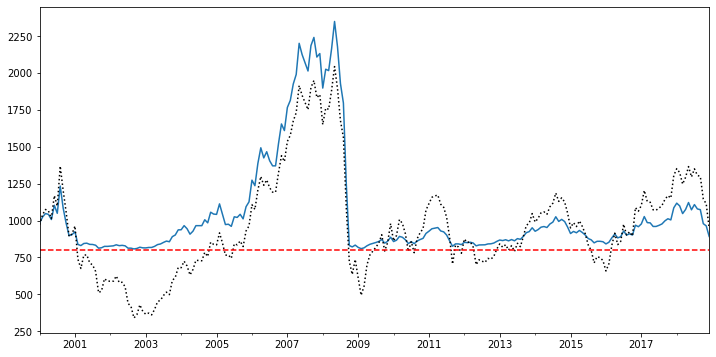

In [19]:
ind="Steel"
ax=account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax,style="k:")
ax.axhline(y=floor_value,color='r',linestyle='--')

In [20]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [21]:
btr= erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())#using percent change to convert btr into returns format, and dropping the NaNs.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


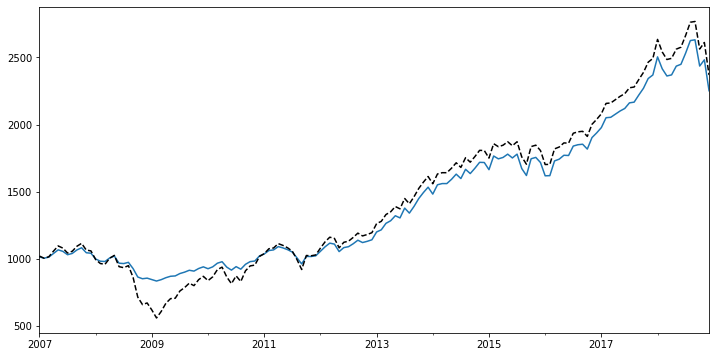

In [22]:
btr=erk.run_cppi(tmi_return["2007":])
ax= btr["Wealth"].plot(figsize=(12,6),legend=False)
btr["Risky Wealth"].plot(ax=ax,style="k--",legend= False)

# Drawdown Constraint

In [23]:
btr=erk.run_cppi(ind_return["2007":][["Steel","Fin","Beer"]],drawdown=0.30)

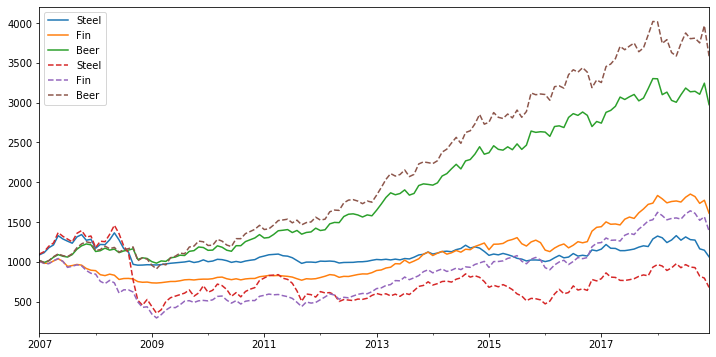

In [24]:
ax= btr["Wealth"].plot(figsize=(12,6),legend=True)
btr["Risky Wealth"].plot(ax=ax,style="--",legend= True)

In [25]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [26]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.001991,0.108504,-0.671669,6.284153,0.054637,0.079461,-0.287079,-0.298175
Fin,0.040382,0.099609,-0.401420,4.370363,0.045805,0.065666,0.101320,-0.293584
Beer,0.094440,0.102950,-0.746486,4.548871,0.045770,0.061699,0.609112,-0.197276


# Note the difference! In the case where we implemented the cppi, the max drawdown never exceeded 0.3. We can hence put a cap and restrict our drawdowns!